In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo

In [2]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")
# test.describe()

In [4]:
# onehot encoder for ingredients
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
expandedLabelData_train = mlb.fit_transform(train["ingredients"])
labelClasses = mlb.classes_
expandedLabelData_test = mlb.fit_transform(test["ingredients"])
labelClasses_2 = mlb.classes_

expandedLabels_train = pd.DataFrame(expandedLabelData_train, columns=labelClasses)
expandedLabels_test = pd.DataFrame(expandedLabelData_test, columns=labelClasses_2)

In [5]:
# shuffle data
def shuffle(df_origin): 
    df = df_origin.sample(frac=1,random_state=113)#,random_state=113
    df2= df.reset_index(drop=True)
    return df2

df = pd.DataFrame(train.cuisine)
df = pd.concat([df,expandedLabels_train], axis = 1)
df_shuffle_train = shuffle(df)
# print(df_shuffle_train)
df = pd.DataFrame(test.id)
df = pd.concat([df,expandedLabels_test], axis = 1)
df_shuffle_test = shuffle(df)
print(df_shuffle_test)


         id  (    oz.) tomato sauce  \
0      9356                       0   
1     31575                       0   
2      3603                       0   
3      5099                       0   
4     13393                       0   
...     ...                     ...   
9995  24775                       0   
9996   7449                       0   
9997  19211                       0   
9998   8966                       0   
9999  29738                       0   

      (10 oz.) frozen chopped spinach, thawed and squeezed dry  \
0                                                     0          
1                                                     0          
2                                                     0          
3                                                     0          
4                                                     0          
...                                                 ...          
9995                                                  0          
999

In [63]:
#PCA for lower down dimensionality
from sklearn.decomposition import PCA
N_COMPONENTS = 512
pca = PCA(N_COMPONENTS)
pca.fit(df_shuffle_train[df_shuffle_train.columns[1:]])
df_shuffle_train_pca = pd.DataFrame(pca.transform(df_shuffle_train[df_shuffle_train.columns[1:]]))
df_shuffle_train_pca.head()
pca.fit(df_shuffle_test[df_shuffle_test.columns[1:]])
df_shuffle_test_pca = pd.DataFrame(pca.transform(df_shuffle_test[df_shuffle_test.columns[1:]]))

In [6]:
#transform cuisine
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_shuffle_train.cuisine)

df_shuffle_train.cuisine = le.transform(df_shuffle_train.cuisine)
print(df_shuffle_train.cuisine)

0         9
1         6
2        12
3        13
4         7
         ..
29769     5
29770    11
29771     9
29772    11
29773     9
Name: cuisine, Length: 29774, dtype: int32


In [7]:
# train_test_split
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(df_shuffle_train.drop(['cuisine'],axis = 1), df_shuffle_train.cuisine, random_state=42, test_size=0.30)
print(len(train_x))
print()
print(len(test_x))

20841

8933


In [84]:
# validation--> SVM
from sklearn.svm import SVC

svm_clf_lin = SVC(random_state=42,kernel='linear')
svm_clf_poly = SVC(random_state=42,kernel='poly')
svm_clf_rbf = SVC(random_state=42,kernel='rbf')
svm_clf_sigmoid = SVC(random_state=42,kernel='sigmoid')

svm_clf_lin = svm_clf_lin.fit(train_x,train_y)
svm_clf_poly = svm_clf_poly.fit(train_x,train_y)
svm_clf_rbf = svm_clf_rbf.fit(train_x,train_y)
svm_clf_sigmoid = svm_clf_sigmoid.fit(train_x,train_y)

In [ ]:
pred = []
pred.append(svm_clf_lin.predict(test_x))
pred.append(svm_clf_poly.predict(test_x))
pred.append(svm_clf_rbf.predict(test_x))
pred.append(svm_clf_sigmoid.predict(test_x))

0
recall:  0.7069293630359341
precision:  0.6418479454005453
accuracy:  0.7069293630359341

1
recall:  0.5870368297324527
precision:  0.7730542549563993
accuracy:  0.5870368297324527

2
recall:  0.7151013097503638
precision:  0.7338202431688018
accuracy:  0.7151013097503638

3
recall:  0.6990932497481249
precision:  0.6821122377032033
accuracy:  0.6990932497481249



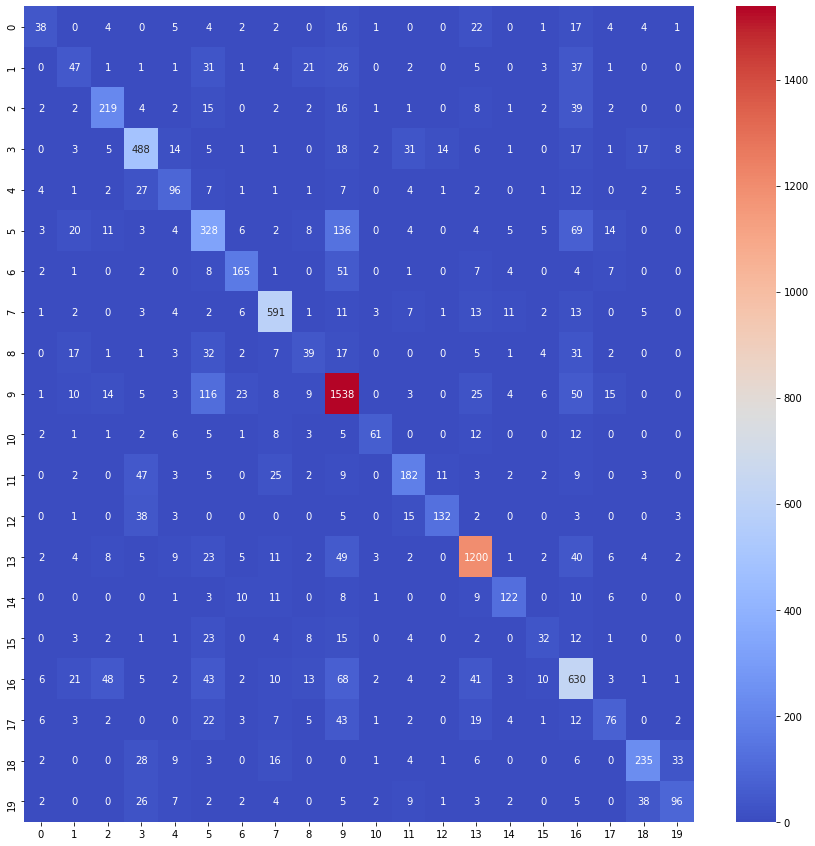

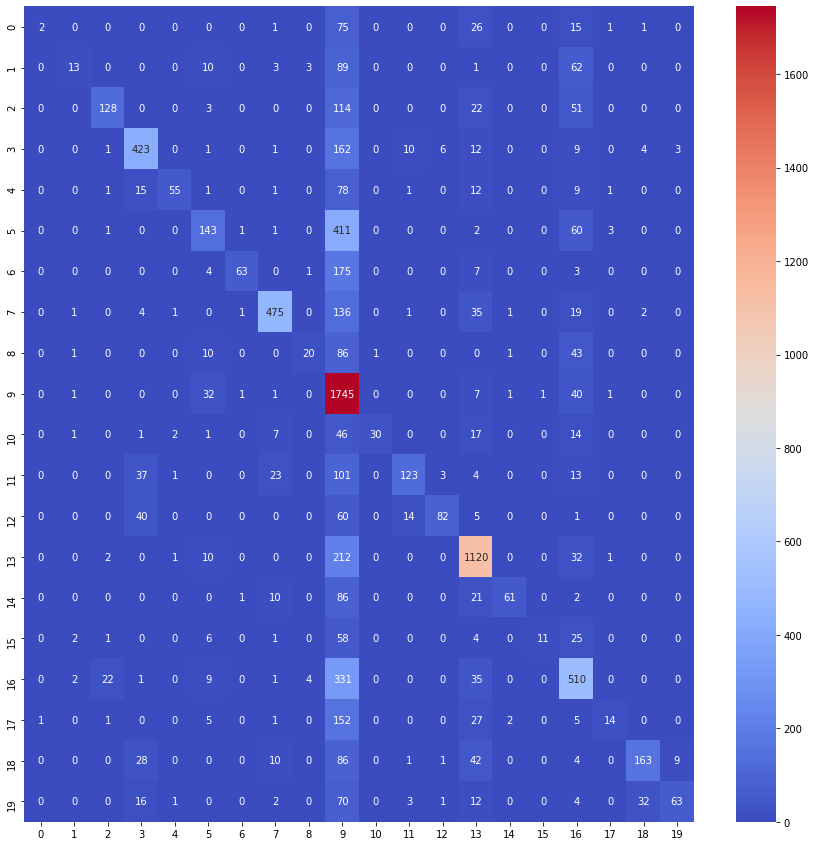

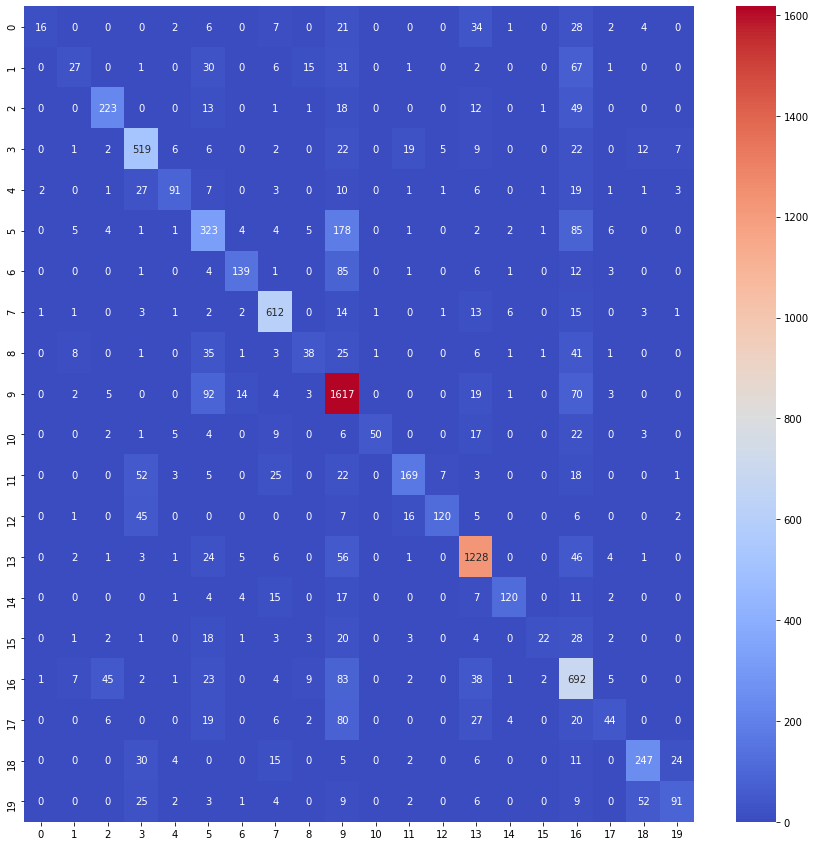

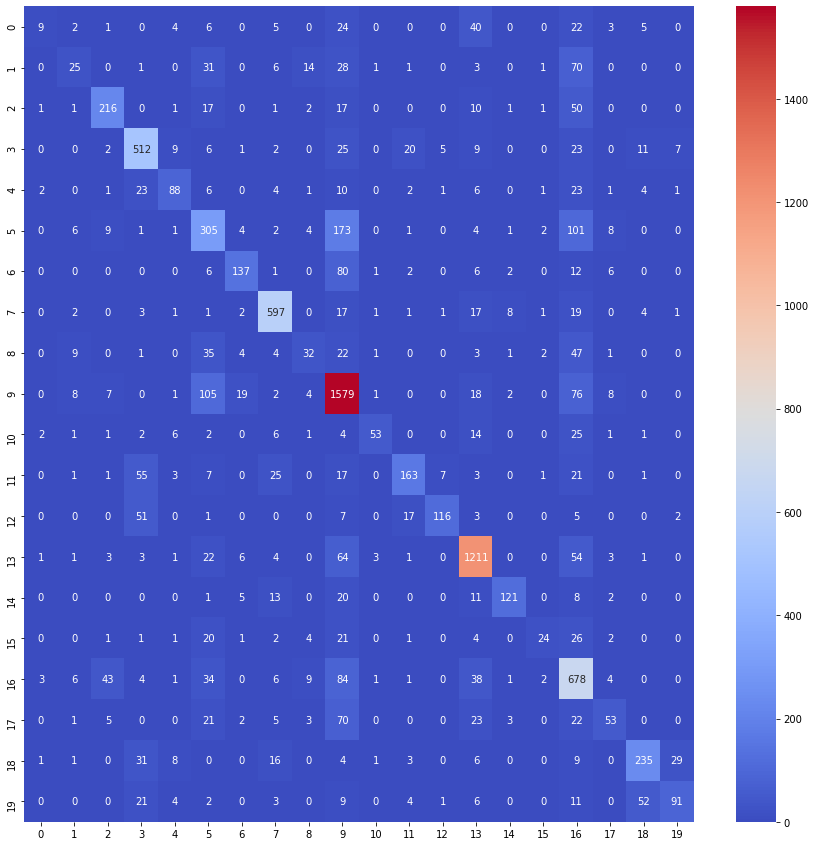

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

for i in range(len(pred)):
    print(i)
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(confusion_matrix(test_y, pred[i]),annot=True,cmap='coolwarm',fmt='d')
    print("recall: ", recall_score(test_y, pred[i], average='micro'))
    print("precision: ", precision_score(test_y, pred[i], average='macro'))
    print("accuracy: ", accuracy_score(test_y, pred[i]))
    print()
    plt.savefig(str(i))
    

In [ ]:
submit = le.inverse_transform(pd.Series(pred[2]))
submit = pd.concat([pd.Series(df_shuffle_test.id, name='Id'), pd.Series(submit, name='Category')], axis=1)
print(submit.to_csv(index=False))
submit.to_csv("submission.csv", index = False)

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_x = train_x.astype("float32")
train_y = train_y.astype("float32")
test_x = test_x.astype("float32")
test_y = test_y.astype("float32")
# Reserve 8933 samples for validation
val_x = train_x[-8933:]
val_y = train_y[-8933:]
train_x = train_x[:-8933]
train_y = train_y[:-8933]

Epoch 1/20
93/93 [==============================] - 1s 15ms/step - loss: 2.9890 - sparse_categorical_accuracy: 0.0736 - val_loss: 2.9744 - val_sparse_categorical_accuracy: 0.0925
Epoch 2/20
93/93 [==============================] - 1s 13ms/step - loss: 2.9619 - sparse_categorical_accuracy: 0.1113 - val_loss: 2.9502 - val_sparse_categorical_accuracy: 0.1286
Epoch 3/20
93/93 [==============================] - 1s 12ms/step - loss: 2.9353 - sparse_categorical_accuracy: 0.1543 - val_loss: 2.9263 - val_sparse_categorical_accuracy: 0.1690
Epoch 4/20
93/93 [==============================] - 1s 11ms/step - loss: 2.9089 - sparse_categorical_accuracy: 0.1953 - val_loss: 2.9023 - val_sparse_categorical_accuracy: 0.2100
Epoch 5/20
93/93 [==============================] - 1s 11ms/step - loss: 2.8822 - sparse_categorical_accuracy: 0.2390 - val_loss: 2.8781 - val_sparse_categorical_accuracy: 0.2469
Epoch 6/20
93/93 [==============================] - 1s 11ms/step - loss: 2.8553 - sparse_categorical_accu

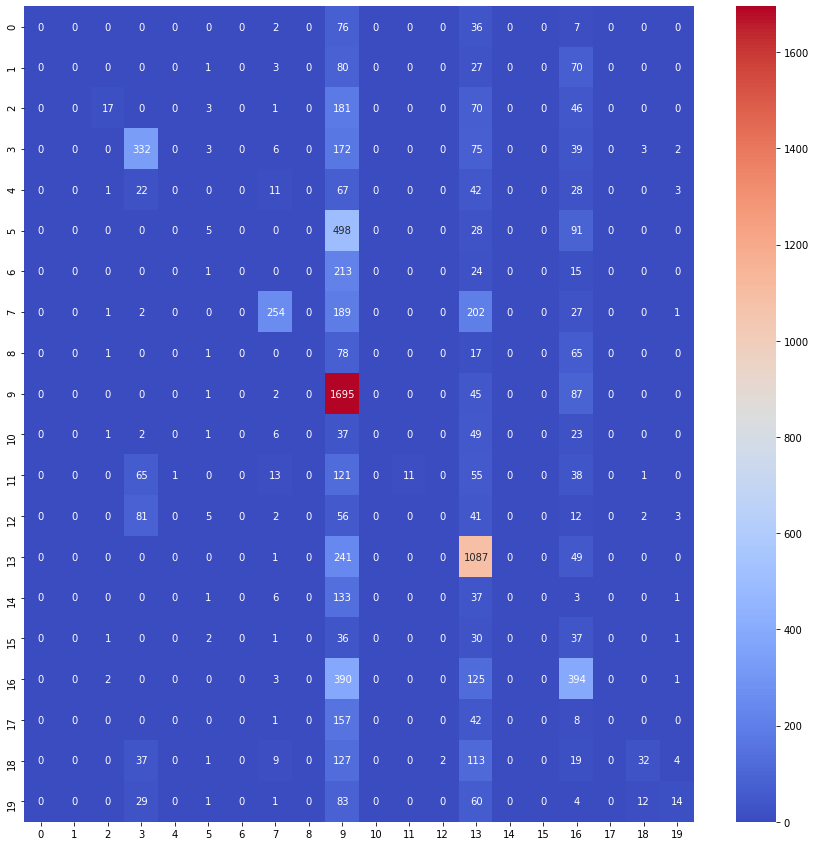

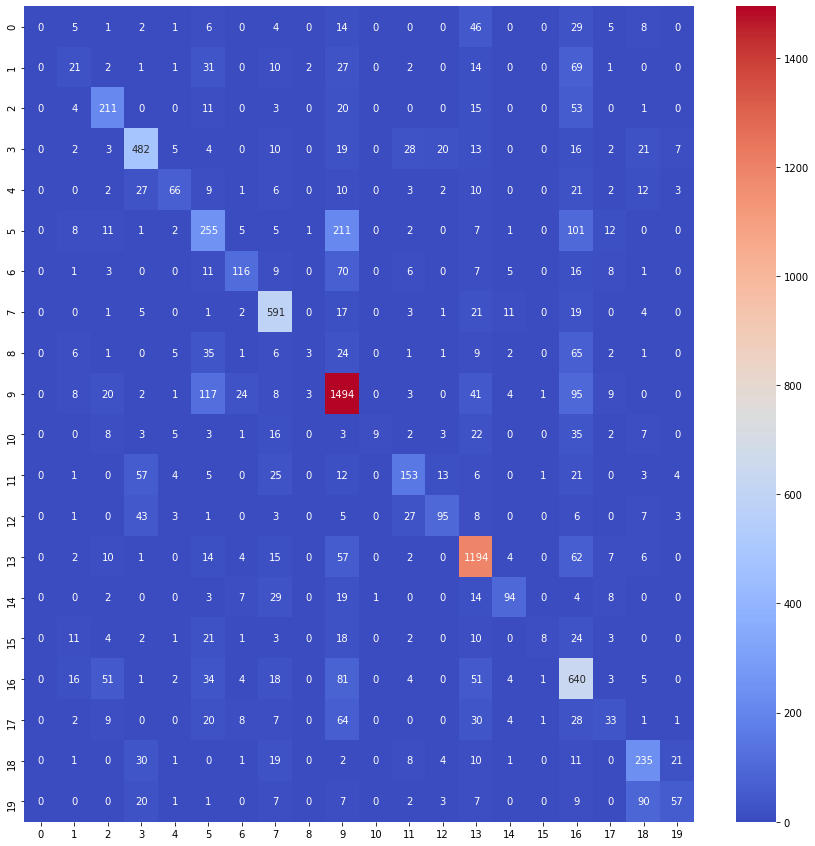

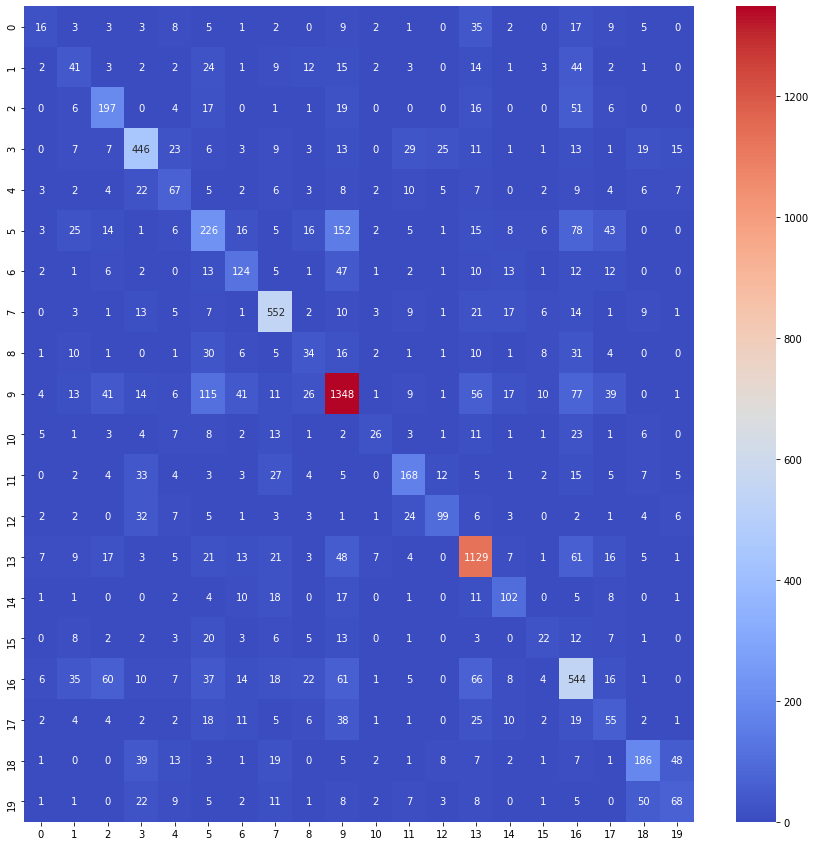

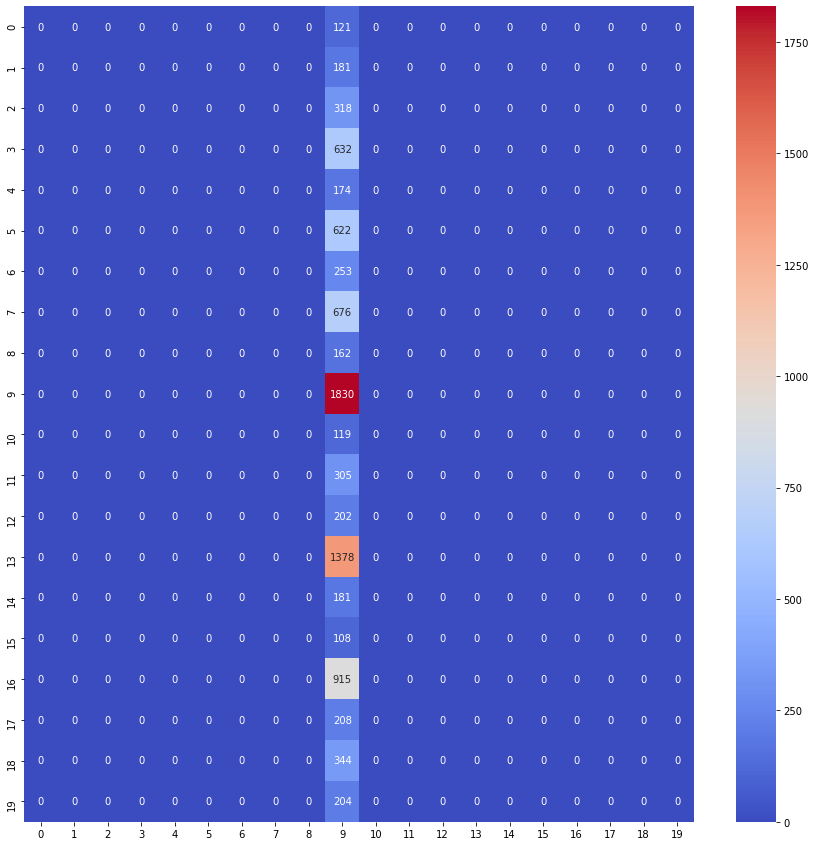

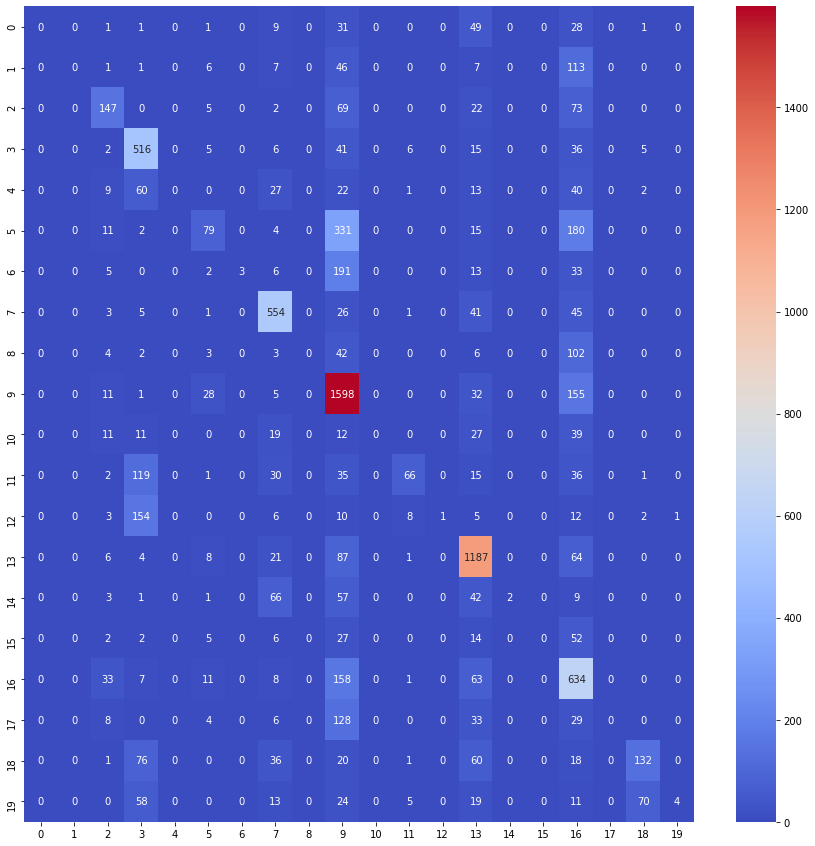

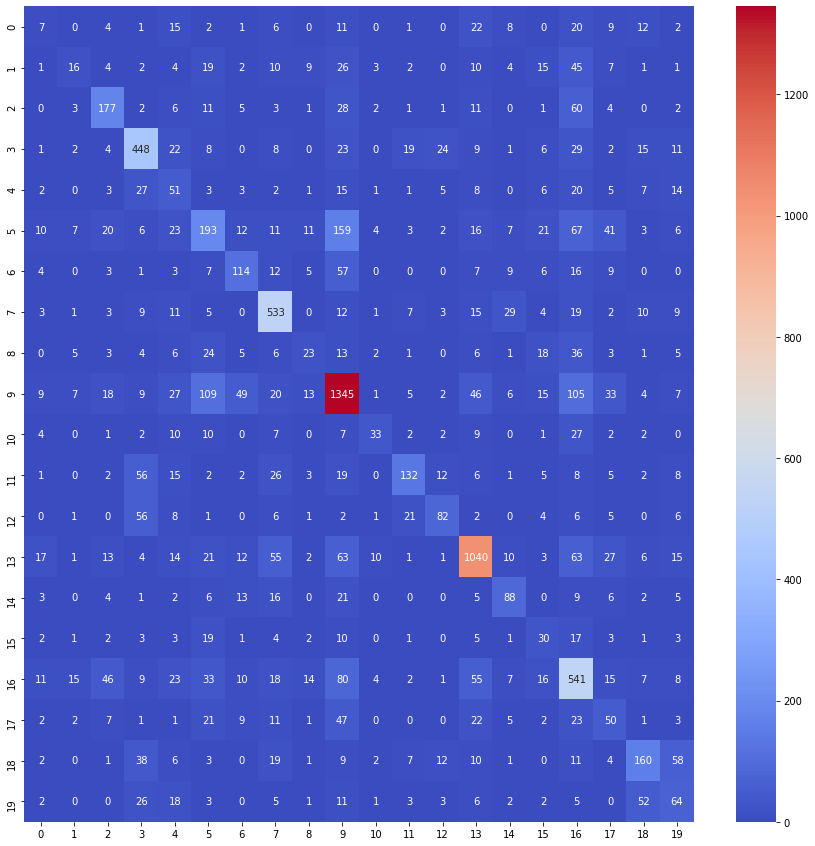

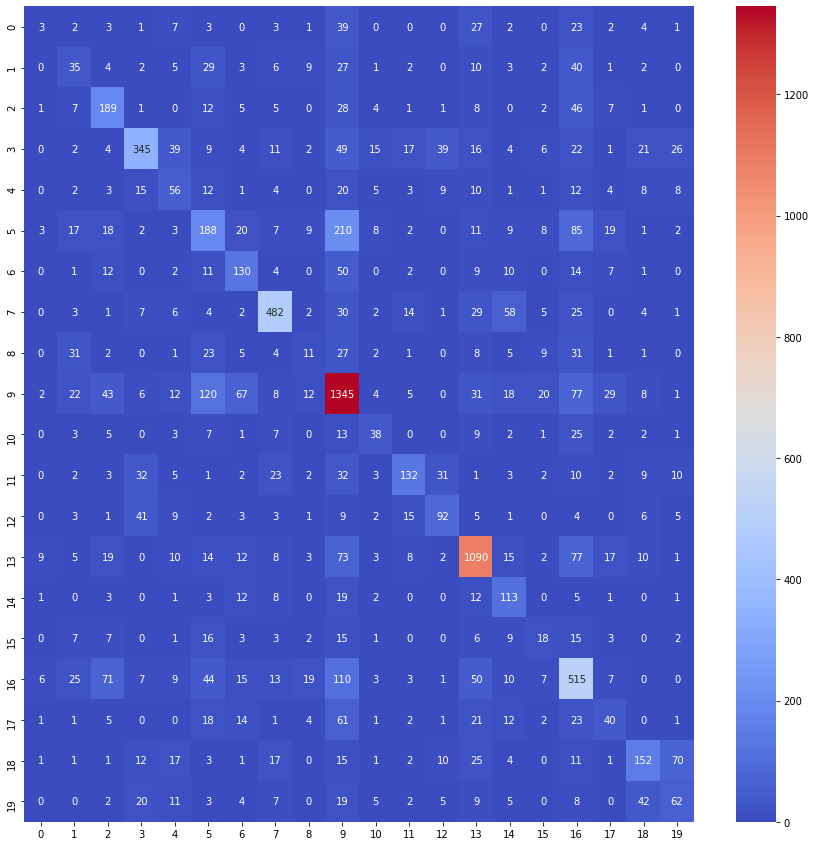

In [25]:
n = ["Adadelta","Adagrad", "Adam", "Ftrl", "SGD", "RMSprop", "Nadam"]
m = [tf.keras.optimizers.Adadelta(0.01), tf.keras.optimizers.Adagrad(0.01), tf.keras.optimizers.Adam(0.001), tf.keras.optimizers.Ftrl(0.01), tf.keras.optimizers.SGD(0.01), tf.keras.optimizers.RMSprop(0.01), tf.keras.optimizers.Nadam(0.01)]

for i in range(len(m)):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(20)
    ])

    model.compile(
        optimizer=m[i],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    model.fit(
        train_x.values, train_y.values,
        epochs=20,
        validation_data=(val_x.values, val_y.values)
    )

    # model.summary()
    y = model.predict(test_x.values)
    pred = []
    for j in range(len(y)):
        pred.append(np.argmax(y[j]))
    # print(pred)

    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(confusion_matrix(test_y, pred),annot=True,cmap='coolwarm',fmt='d')
    print(n[i])
    print("recall: ", recall_score(test_y, pred, average='micro'))
    print("precision: ", precision_score(test_y, pred, average='macro'))
    print("accuracy: ", accuracy_score(test_y, pred))
    print()
    plt.savefig('EMG {0}.jpg'.format(i)) 


In [ ]:
submit_nn = le.inverse_transform(pd.Series(pred[2]))
submit_nn = pd.concat([pd.Series(df_shuffle_test.id, name='Id'), pd.Series(submit_nn, name='Category')], axis=1)
print(submit_nn)
submit_nn.to_csv("submission_nn.csv", index = False)